In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import glob
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import re

try:
    gpu = tf.distribute.cluster_resolver.GPUClusterResolver()
    print('Device:',gpu.master())
    tf.config.experimental_connect_to_cluster(gpu)
    tf.gpu.experimental.initialize_gpu_system(gpu)
    strategy = tf.distribute.experimental.GPUStrategy(gpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

#print versions
print('tensorflow version',tf.__version__)


path=os.getcwd()
print(path)

Number of replicas: 1
tensorflow version 2.3.1
/home/wcislab/NTHU_Medical


In [2]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [3]:
def print_results(y_test, y_pred):
    print('Accuracy   : {:.5f}'.format(accuracy_score(y_pred , y_test))) 
    print('AUC        : {:.5f}'.format(roc_auc_score(y_test , y_pred)))
    print('Precision  : {:.5f}'.format(precision_score(y_test , y_pred)))
    print('Recall     : {:.5f}'.format(recall_score(y_test , y_pred)))
    print('F1         : {:.5f}'.format(f1_score(y_test , y_pred)))
    print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

In [4]:
#Load Data
train_path = path+'/chest_xray/train'
val_path = path+'/chest_xray/val'
test_path = path+'/chest_xray/test2'
test_path2 = path+'/chest_xray/test'

In [5]:
train_files_original = glob.glob(train_path+'/*/*')
val_files_original = glob.glob(val_path+'/*/*')
test_files = glob.glob(test_path+'/*')

print('number of train samples across classes:', len(train_files_original))
print('number of val samples across classes:', len(val_files_original))
print('number of test samples across classes:', len(test_files))


# print(test_files)
# print(test_files[:624])

number of train samples across classes: 5216
number of val samples across classes: 16
number of test samples across classes: 624


In [6]:
#Process Inputs-As you can see, there are only 16 samples in validation set (~0.3%), we would prefer to have a greater proportion of samples included in validation set. Let's create a 80:30 split between train and test
files = np.unique(train_files_original + val_files_original)
train_files, val_files = train_test_split(files, test_size=0.2, shuffle=True)

print('number of train samples:', len(train_files))
print('number of val samples:', len(val_files))

number of train samples: 4185
number of val samples: 1047


In [7]:
count_normal = len([x for x in train_files if 'NORMAL' in x])
count_pneumonia = len([x for x in train_files if 'PNEUMONIA' in x])

print('Count of NORMAL images in train:', count_normal)
print('Count of PNEUMONIA images in train:', count_pneumonia)

Count of NORMAL images in train: 1069
Count of PNEUMONIA images in train: 3116


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/home/wcislab/NTHU_Medical/chest_xray/train/PNEUMONIA/person1368_virus_2352.jpeg'
b'/home/wcislab/NTHU_Medical/chest_xray/train/PNEUMONIA/person1133_virus_1865.jpeg'
b'/home/wcislab/NTHU_Medical/chest_xray/train/PNEUMONIA/person985_bacteria_2912.jpeg'
b'/home/wcislab/NTHU_Medical/chest_xray/train/PNEUMONIA/person863_virus_1508.jpeg'
b'/home/wcislab/NTHU_Medical/chest_xray/train/PNEUMONIA/person1673_bacteria_4434.jpeg'


In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(path + "/chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [11]:

#輸出第一張原圖的size/max/min/mean
originalimage=cv2.imread(train_files[1])
print("------------------------------size-----------------------------")
print("Original Image shape: ", originalimage.shape)
print("\n\n")
print("------------------------------max value-----------------------------")
print("Original Image max-axis=0: ", originalimage.max(axis=(0)))
print("Original Image max-axis=1: ", originalimage.max(axis=(1)))
print("Original Image max-axis=2: ", originalimage.max(axis=(2)))
print("\n\n")
print("------------------------------min value-----------------------------")
print("Original Image min-axis=0: ", originalimage.min(axis=(0)))
print("Original Image min-axis=1: ", originalimage.min(axis=(1)))
print("Original Image min-axis=2: ", originalimage.min(axis=(2)))
print("\n\n")
print("------------------------------mean value-----------------------------")
print("Original Image mean-axis=0: ", originalimage.mean(axis=(0)))
print("Original Image mean-axis=1: ", originalimage.mean(axis=(1)))
print("Original Image mean-axis=2: ", originalimage.mean(axis=(2)))



------------------------------size-----------------------------
Original Image shape:  (427, 722, 3)



------------------------------max value-----------------------------
Original Image max-axis=0:  [[138 138 138]
 [134 134 134]
 [135 135 135]
 ...
 [ 54  54  54]
 [ 53  53  53]
 [ 53  53  53]]
Original Image max-axis=1:  [[196 196 196]
 [193 193 193]
 [194 194 194]
 ...
 [208 208 208]
 [208 208 208]
 [208 208 208]]
Original Image max-axis=2:  [[132 131 130 ...  54  53  53]
 [132 131 129 ...  50  51  51]
 [131 130 129 ...  47  48  48]
 ...
 [  1   0   0 ...  40  39  39]
 [  1   0   0 ...  40  39  39]
 [  1   0   0 ...  40  39  39]]



------------------------------min value-----------------------------
Original Image min-axis=0:  [[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
Original Image min-axis=1:  [[53 53 53]
 [50 50 50]
 [47 47 47]
 ...
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]]
Original Image min-axis=2:  [[132 131 130 ...  54  53  53]
 [132 131 129 ...  50  51  51]
 [1

In [12]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [13]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
#輸出修改後第一張原圖的size/max/min/mean
for image, label in train_ds.take(1):
    print("------------------------------size-----------------------------")
    print("Process Image shape: ", image.numpy().shape)
    print("\n\n")
    print("------------------------------max value-----------------------------")
    print("Image max-axis=0: ", image.numpy().max(axis=(0)))
    print("Image max-axis=1: ", image.numpy().max(axis=(1)))
    print("Image max-axis=2: ", image.numpy().max(axis=(2)))
    print("\n\n")
    print("------------------------------min value-----------------------------")
    print("Image max-axis=0: ", image.numpy().min(axis=(0)))
    print("Image max-axis=1: ", image.numpy().min(axis=(1)))
    print("Image max-axis=2: ", image.numpy().min(axis=(2)))
    print("\n\n")
    print("------------------------------mean value-----------------------------")
    print("Image max-axis=0: ", image.numpy().mean(axis=(0)))
    print("Image max-axis=1: ", image.numpy().mean(axis=(1)))
    print("Image max-axis=2: ", image.numpy().mean(axis=(2)))
    #判斷label狀況
    print("\n\n")
    print("Label: ", label.numpy())
    

------------------------------size-----------------------------
Process Image shape:  (180, 180, 3)



------------------------------max value-----------------------------
Image max-axis=0:  [[0.7039342  0.7039342  0.7039342 ]
 [0.6341905  0.6341905  0.6341905 ]
 [0.6657226  0.6657226  0.6657226 ]
 [0.68667436 0.68667436 0.68667436]
 [0.70153815 0.70153815 0.70153815]
 [0.7041424  0.7041424  0.7041424 ]
 [0.6950763  0.6950763  0.6950763 ]
 [0.7121786  0.7121786  0.7121786 ]
 [0.7210849  0.7210849  0.7210849 ]
 [0.73202616 0.73202616 0.73202616]
 [0.7585782  0.7585782  0.7585782 ]
 [0.72681487 0.72681487 0.72681487]
 [0.8202858  0.8202858  0.8202858 ]
 [0.8922442  0.8922442  0.8922442 ]
 [0.9992593  0.9992593  0.9992593 ]
 [0.99387956 0.99387956 0.99387956]
 [0.9976006  0.9976006  0.9976006 ]
 [0.9912611  0.9912611  0.9912611 ]
 [0.9870635  0.9870635  0.9870635 ]
 [0.92692816 0.92692816 0.92692816]
 [0.9280465  0.9280465  0.9280465 ]
 [0.94040537 0.94040537 0.94040537]
 [0.9514162  0.95

In [17]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [18]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

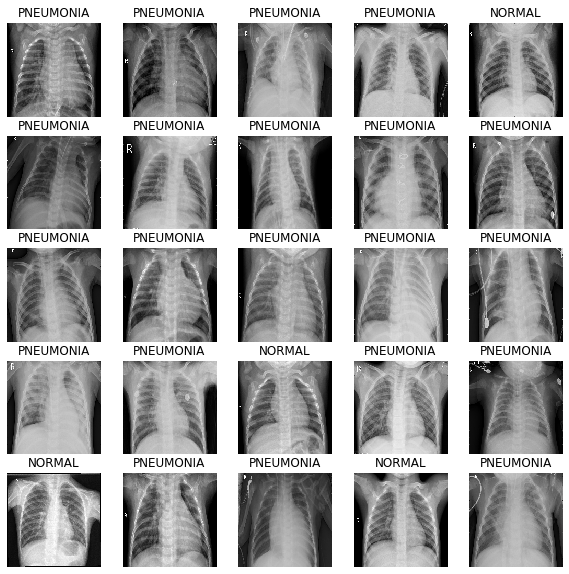

In [20]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [21]:
#Build CNN-The architecture for this CNN(block&dense layer)
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [22]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
#Correct for data imbalance
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias


array([1.0698265])

In [25]:
weight_for_0 = (1 / count_normal)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / count_pneumonia)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


In [26]:
#Train the model
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
32/32 [==============================] - 70s 2s/step - loss: 0.4476 - accuracy: 0.7466 - precision: 0.9531 - recall: 0.6935 - val_loss: 0.7085 - val_accuracy: 0.2695 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
27/32 [========================>.....] - ETA: 8s - loss: 0.2440 - accuracy: 0.8941 - precision: 0.9800 - recall: 0.8759 

In [ ]:
# Finetune the model-checkpoint callback saves the best weights of the model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
#Finetune our learning rate
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=20,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_list_ds = tf.data.Dataset.list_files(str(path + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
# TEST_IMAGE_COUNT


In [ ]:
# #Preepare test data
# from keras.utils import to_categorical
# test_data = []
# test_labels = []
# for img in test_files:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (180,180))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
# #     label = to_categorical(0, num_classes=2)
#     test_data.append(img)
# #     test_labels.append(label)
    
# test_data = np.array(test_data)
# # test_labels = np.array(test_labels)

# print("Total number of test examples: ", test_data.shape)
# # print("Total number of labels:", test_labels.shape)


In [ ]:
test_data = []
IMG_SIZE = 180
for img in test_files:
    img_arr = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    resized_arr = cv2.resize(img_arr, (IMG_SIZE ,IMG_SIZE))
    test_data.append(resized_arr)

    
test = np.array(test_data)
print(test.shape)

In [ ]:
x_test = []
for feature in test:
    x_test.append(feature)
    
      

x_test = np.array(x_test) / 255.
x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(len(x_test))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()
for i in range(3):
    ax[i].imshow(x_test[i].reshape(180,180), cmap='gray')

In [ ]:
# loss, acc, prec, rec = model.evaluate(test_ds)
loss, acc, prec, rec = model.evaluate(test_ds)

In [ ]:
# prediction=model.predict(x_test)
# label_pred = np.round(prediction).reshape(1,-1)[0]
# #印出test 624張圖的預測結果,0為Normal, 1為PNEUMONIA
# print(label_pred)
# def countX(lst, x):
#     count = 0
#     for ele in lst:
#         if (ele == x):
#             count = count + 1
#     return count

# print(countX(label_pred, 1.))
# # plt.plot(prediction)
# # plt.plot(label_pred)

In [ ]:
# import seaborn as sns
# plt.title("NORMAL/PNOMONİA")
# plt.show()
# print(label_pred["0."].value_counts())

In [ ]:
sub=pd.read_csv(path+'/predict.csv',sep=',')
sub['predict']=label_pred
# sub.to_csv(path+'/result.csv',index=False)